# Berechnung der gemittelten Pitchwinkel

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cdflib
from virtual_detector import *
# %matplotlib widget

In [2]:
# step_main = cdflib.CDF('data/STEP_main/2021/solo_L2_epd-step-main_20211204_V01.cdf')

In [3]:
def step_plot(self,xlabel,ylabel,title):
    '''Erzeugt den bekannten STEP-Plot mit allen 16 Pixeln. Gibt Liste mit axes zurück.'''
    fig = plt.figure(figsize = (15,10))
    fig.subplots_adjust(wspace = 0, hspace = 0)
    ax = []        
    for i in range(16):
        if i == 0:
            ax.append(fig.add_subplot(4,5,3))
        else:
            if i == 1:
                ax.append(fig.add_subplot(4,5,5+i))
            else:
                ax.append(fig.add_subplot(4,5,5+i,sharex = ax[1], sharey = ax[1]))              
            if i == 6:
                ax[i].set_ylabel(ylabel)
            if i == 13:
                ax[i].set_xlabel(xlabel)
        if i not in [0,1,6,11]:
            for t in ax[i].get_yticklabels():
                t.set_visible(False)
        if i < 11:
            for t in ax[i].get_xticklabels():
                t.set_visible(False)
    ax[0].set_title(title)
    return fig, ax

In [4]:
def pw(flow,B):
    '''Übergebe den particle flow-Vektor als Geschwindigkeit und den Magnetfeldvektor (am besten in SRF) und berechne die Pitchwinkel über das Skalarprodukt.
    Rückgabe in Radians und Grad'''
    len_flow = np.sqrt(flow[0]**2 + flow[1]**2 + flow[2]**2)
    len_B = np.sqrt(B[0]**2 + B[1]**2 + B[2]**2)
    argument = (flow[0]*B[0] + flow[1]*B[1] + flow[2]*B[2])/len_flow/len_B
    result = np.arccos(argument)
    return result, np.degrees(result)     # Radians, Degree

def average_pw(self,pix):
    '''Rückgabe des gemittelten Pitchwinkels in Radians und Grad, pix ist der Pixelindex (0 als Background-Pixel)'''
    sum = 0.0
    sum_hitfrac = 0.0

    for phii in range(self.cosmu.shape[0]):
        for thetai in range(self.cosmu.shape[1]):
            # Beachten, dass mu in Grad gegeben ist
            pitchangle = self.mu[phii][thetai]
            sum += self.hitfrac[pix][phii][thetai] * pitchangle
            sum_hitfrac += self.hitfrac[pix][phii][thetai]
    av_pw = sum/sum_hitfrac
    return av_pw*np.pi/180, av_pw     # Radians, Degree

def plot_pw(pw_list,title):
    '''STEP-Plot mit Pitch-Winkeln.'''
    fig, ax = plt.subplots()
    x_corners = [0,1,2,3,4,5]
    y_corners = [0,1,2,3]
    # Liste mit Pitchwinkeln muss für das colormesh für axis=0 gedreht werden
    pw_list = np.flip(pw_list,axis=0)
    tmp = ax.pcolormesh(x_corners,y_corners,pw_list)
    plt.colorbar(tmp,label=r'pitch angle $\varphi$ [°]')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(title)

def plot_pw_sanity_check(pw_list, av_pw_list, vmin, vmax, direction_mag):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1,figsize=(8,16))
    x_corners = [0,1,2,3,4,5]
    y_corners = [0,1,2,3]

    # Liste mit Pitchwinkeln muss für das colormesh für axis=0 gedreht werden

    # Pitchwinkel mit particle flow vector
    pw_list = np.flip(pw_list,axis=0)
    tmp = ax1.pcolormesh(x_corners,y_corners,pw_list,vmin=vmin,vmax=vmax)
    plt.colorbar(tmp,label=r'pitch angle $\varphi$ [°]')
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    ax1.set_title(f'pitch angle via particle flow vector - mag in direction of flow vector for pixel {direction_mag}')

    # Pitchwinkel gemittelt mit virtual_detector.py
    av_pw_list = np.flip(av_pw_list,axis=0)
    tmp = ax2.pcolormesh(x_corners,y_corners,av_pw_list,vmin=vmin,vmax=vmax)
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    ax2.set_title('average pitch angle via virtual_detector.py')

    # flow vector - virtual_detector
    diff = pw_list-av_pw_list
    vmax_abs = abs(diff).max()
    tmp = ax3.pcolormesh(x_corners,y_corners,pw_list-av_pw_list,vmin=-vmax_abs,vmax=vmax_abs,cmap=mpl.cm.seismic)
    plt.colorbar(tmp,label=r'pitch angle difference $\Delta\varphi$ [°]')
    ax3.get_xaxis().set_visible(False)
    ax3.get_yaxis().set_visible(False)
    ax3.set_title('pitch angle difference')


### Sanity Check - Nutze particle flow vector des zentralen Pixels als Richtung des Magnetfeldes ###

# Ich vermute, dass das Koordinatensystem aus virtual_detector.py einfach nur SRF mit gedrehtem X und Y ist.
# Lars meint, dass es einfach SRF ist
# particle-flow vector funktioniert in SRF mit und ohne Drehung komisch...
flow_vector_srf = np.array([[-0.8412,  0.4396,  0.3149], [-0.8743,  0.457,   0.1635], [-0.8862,  0.4632, -0.    ], [-0.8743,  0.457,  -0.1635], [-0.8412,  0.4396, -0.315 ], [-0.7775,  0.5444,  0.3149], [-0.8082,  0.5658,  0.1635], [-0.8191,  0.5736,  0.    ], [-0.8082,  0.5659, -0.1634], [-0.7775,  0.5444, -0.3149], [-0.7008,  0.6401,  0.3149], [-0.7284,  0.6653,  0.1634], [-0.7384,  0.6744, -0.    ], [-0.7285,  0.6653, -0.1635], [-0.7008,  0.6401, -0.315 ]])
flow_vector_lars_xyz = np.array([-1*flow_vector_srf.T[0], -1*flow_vector_srf.T[1],flow_vector_srf.T[2]]).T


# Berechnung über den virtual detector

# pixel_list = range(16)
# av_pw_list = np.zeros((3,5))

# B = flow_vector_lars_xyz#[7:8]
# for k, mag in enumerate(B):
#     pixel = 0
#     # kleinen Offset drauf wegen Computergenauigkeit
#     mag = mag + np.array([0,0,0.001])
#     mag_det = VDSTEP(B=mag)
#     for i in range(3):
#         for j in range(5):
#             av_pw_list[i][j] = average_pw(mag_det,pixel+1)[1]
#             pixel += 1   # Index des entsprechenden Pixels wird erhöht
#     plot_pw(av_pw_list,f'average pitch angle via virtual_detector.py - mag in direction of pixel {k+1}')
#plt.close()

# Berechnung über particle flow vector

# pixel_list = range(16)
# pw_list = np.zeros((3,5))

# B = flow_vector_srf
# for k, mag in enumerate(B):
#     pixel = 0
#     # kleinen Offset drauf wegen Computergenauigkeit
#     mag = mag + np.array([0,0,0.001])
#     for i in range(3):
#         for j in range(5):
#             pw_list[i][j] = pw(flow_vector_srf[pixel],mag)[1]
#             pixel += 1   # Index des entsprechenden Pixels wird erhöht
#     plot_pw(pw_list,f'pitch angle via particle flow vector - mag in direction of pixel {k+1}')
#     plt.close()

### Sanity Check - Plot des Vergleichs ###

pixel_list = range(16)
pw_list = np.zeros((3,5))
av_pw_list = np.zeros((3,5))

B_srf = flow_vector_srf
B_lars_xyz = flow_vector_lars_xyz
for k in range(len(B_srf)):
    pixel = 0
    mag_srf = B_srf[k]
    mag_lars_xyz = B_lars_xyz[k]
    # kleinen Offset drauf wegen Computergenauigkeit
    mag_srf = mag_srf + np.array([0,0,0.001])
    mag_lars_xyz = mag_lars_xyz + np.array([0,0,0.001])
    mag_det_lars_xyz = VDSTEP(B=mag_lars_xyz)
    for i in range(3):
        for j in range(5):
            pw_list[i][j] = pw(flow_vector_srf[pixel],mag_srf)[1]
            av_pw_list[i][j] = average_pw(mag_det_lars_xyz,pixel+1)[1]
            pixel += 1   # Index des entsprechenden Pixels wird erhöht
    vmax = max(pw_list.max(),av_pw_list.max())
    vmin = min(pw_list.min(),av_pw_list.min())
    plot_pw_sanity_check(pw_list,av_pw_list,vmin=vmin,vmax=vmax,direction_mag=k+1)
    plt.savefig(f'average_pw_testing/mag_direction_flowvector_pixel_{k+1}.png')
    plt.close()
    print(pw_list)
    print(av_pw_list)
    print(pw_list-av_pw_list)

C:\Users\ebel1\AppData\Local\Temp\ipykernel_11452\3170289469.py:47: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(tmp,label=r'pitch angle $\varphi$ [°]')


[[ 0.05436305  8.99868487 18.40887809 27.8190723  36.76883004]
 [ 7.03018655 11.51095684 19.79688462 28.75747031 37.47702432]
 [14.05728522 16.95153982 23.46787657 31.42534039 39.54631091]]
[[ 5.62018931  7.38837484 18.68209244 30.42648182 41.3196351 ]
 [ 8.89711661 10.12707548 19.99670385 31.39324916 42.17518141]
 [16.49482976 17.66905654 24.81742765 34.54899402 44.38128756]]
[[-5.56582626  1.61031004 -0.27321435 -2.60740952 -4.55080507]
 [-1.86693005  1.38388136 -0.19981922 -2.63577885 -4.69815709]
 [-2.43754454 -0.71751672 -1.34955108 -3.12365363 -4.83497665]]
[[ 8.88780583  0.05651601  9.46671026 18.8769044  27.82666311]
 [11.42382776  7.29855932 11.99896974 20.25846695 28.76451427]
 [16.88633126 14.61008231 17.51990229 23.94986251 31.43261484]]
[[13.69186119  4.78350126 10.04546713 21.55997944 32.41204961]
 [15.57523425  8.50265195 12.41031549 22.86627272 33.42773893]
 [21.00197136 16.90767205 19.39101657 27.15605629 36.25266988]]
[[-4.80405536 -4.72698524 -0.57875687 -2.68307504 

0.0
-16.0 -30.0
0.33219276573844064


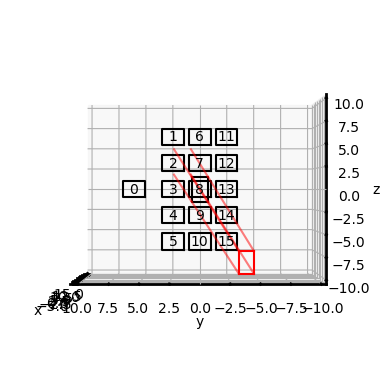

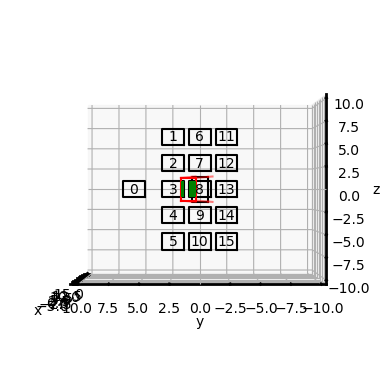

In [7]:
int = VDSTEP()
mag = VDSTEP(mag=True)

pix = 8
phii = 0
thetai = 0
plist = range(16)

plot_FoV(int,phii=phii,thetai=thetai,plist=plist)
print(int.hitfrac[pix][phii][thetai])
print(int.phi_d[phii],int.theta_d[thetai])

pix = 8
phii = 20
thetai = 30
plist = range(16)

plot_FoV(int,phii=phii,thetai=thetai,plist=plist)
print(int.hitfrac[pix][phii][thetai])

# plot_FoV(mag,phii=phii,thetai=thetai,plist=plist)

plt.show()